In [57]:
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import copy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
STOP_WORDS_EN = set(stopwords.words('english'))
STEMMER = SnowballStemmer('romanian')
MAX_LEN = 32

WORD_TO_INDEX = {}
WORD_TO_INDEX["<mask>"] = 0 
WORD_TO_INDEX["<pad>"] = 1
WORD_TO_INDEX["<unk>"] = 2

def get_tokens(caption):
    caption = caption.lower()
    
    caption = re.sub(r'[^\w\s]', ' ', caption)
    caption = re.sub(r'\s+', ' ', caption)
    caption = word_tokenize(caption)
    
    tokens = []
    for word in caption:
        if word not in STOP_WORDS_EN:
            stemmed_word = STEMMER.stem(word)
            tokens.append(stemmed_word)
    
    return tokens

def build_vocab(tokenized_captions):
    global WORD_TO_INDEX
    vocab = Counter(word for sent in tokenized_captions for word in sent)
    start_id = list(WORD_TO_INDEX.values())[-1]
    increment = 1
    for id, (word, _) in enumerate(vocab.items()):
        if word not in WORD_TO_INDEX:
            WORD_TO_INDEX[word] = start_id + increment
            increment += 1

class CaptionsDataset(Dataset):
    def __init__(self, root, split):
        global WORD_TO_INDEX
        csv_file = pd.read_csv(os.path.join(root, f"{split}.csv"))
        self.split = split

        captions = csv_file["caption"].to_numpy()
        
        tokenized_captions = []
        for caption in captions:
            tokenized_captions.append(get_tokens(caption))

        build_vocab(tokenized_captions)
        
        encoded_captions = []
        masked_captions = []
        self.labels = []
        for tokenized_caption in tokenized_captions:
            encoded_caption = []
            for token in tokenized_caption:
                if token in WORD_TO_INDEX:
                    encoded_caption.append(WORD_TO_INDEX[token])
                else:
                    encoded_caption.append(WORD_TO_INDEX["<unk>"])

            encoded_captions.append(encoded_caption)

            mask_idx = np.random.randint(len(encoded_caption))
            masked_caption = copy.deepcopy(encoded_caption)
            masked_caption[mask_idx] = WORD_TO_INDEX["<mask>"]

            self.labels.append(encoded_caption[mask_idx])
            masked_captions.append(masked_caption)
        
        encoded_captions_padded = []
        masked_captions_padded = []
        for encoded_caption, masked_caption in zip(encoded_captions, masked_captions):
            num_pads = MAX_LEN - len(encoded_caption)
            encoded_captions_padded.append(encoded_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)
            masked_captions_padded.append(masked_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)

        self.data = [encoded_captions_padded, masked_captions_padded]

    def __len__(self):
        return len(self.data[0])
        
    def __getitem__(self, idx):
        sample = self.data[0][idx]
        sample = torch.tensor(sample).int()

        masked_sample = self.data[1][idx]
        masked_sample = torch.tensor(masked_sample).int()

        label = self.labels[idx]
        
        return masked_sample, label

In [59]:
class LanguageModel(nn.Module):
    def __init__(self, params):
        super(LanguageModel, self).__init__()
        if len(params) > 0:
            vocab_size = params["vocab_size"]
            embed_dim = params["embed_dim"]
            hidden_dim = params["hidden_dim"]
            num_layers = params["num_layers"]
            
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden_state, _) = self.lstm(x)
        out = self.linear(hidden_state[-1])
        return out

In [60]:
batch_size = 64
lr = 1e-3
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

root = "/kaggle/input/image-sentence-pair-v2"

train_dataset = CaptionsDataset(root, "train")
val_dataset = CaptionsDataset(root, "val")
test_dataset = CaptionsDataset(root, "test")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

params = {
    "vocab_size": len(WORD_TO_INDEX), 
    "embed_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1
}

In [61]:
def train_step(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    for txt_inputs, labels in tqdm(train_loader):
        txt_inputs, labels = txt_inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(txt_inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(predictions == labels).item()
        total_preds += labels.shape[0]

    train_step_loss = total_loss / len(train_loader)
    train_step_acc = correct_preds / total_preds

    return train_step_loss, train_step_acc

def val_step(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    with torch.no_grad():
        for txt_inputs, labels in tqdm(val_loader):
            txt_inputs, labels = txt_inputs.to(device), labels.to(device)

            outputs = model(txt_inputs)
            loss = loss_fn(outputs, labels)
    
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(predictions == labels).item()
            total_preds += labels.shape[0]

    val_step_loss = total_loss / len(val_loader)
    val_step_acc = correct_preds / total_preds

    return val_step_loss, val_step_acc

def train():
    model = LanguageModel(params).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0.0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_step_loss, train_step_acc = train_step(model, train_dataloader, optimizer, loss_fn)
        print(f"train_step_loss: {train_step_loss} | train_step_acc = {train_step_acc}")
        
        val_step_loss, val_step_acc = val_step(model, val_dataloader, loss_fn)
        print(f"val_step_loss: {val_step_loss} | val_step_acc = {val_step_acc}")

        train_losses.append(train_step_loss)
        train_accs.append(train_step_acc)
        val_losses.append(val_step_loss)
        val_accs.append(val_step_acc)

        if val_step_acc > best_acc:
            best_acc = val_step_acc
            torch.save(model.state_dict(), "language_model.pt")

    plt.plot(range(epochs), train_losses)
    plt.title("Train loss")
    plt.savefig("train_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), train_accs)
    plt.title("Train acc")
    plt.savefig("train_acc.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_losses)
    plt.title("Val loss")
    plt.savefig("val_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_accs)
    plt.title("Val acc")
    plt.savefig("val_acc.jpg")
    plt.plot()

epoch: 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.9213397821803 | train_step_acc = 0.0195


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.7769982459697315 | val_step_acc = 0.021
epoch: 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.5254701930246535 | train_step_acc = 0.0208


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.856233069237242 | val_step_acc = 0.021
epoch: 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.4931719652406725 | train_step_acc = 0.0204


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.868384696067648 | val_step_acc = 0.021
epoch: 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.492041059360383 | train_step_acc = 0.0201


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.8760449125411665 | val_step_acc = 0.021
epoch: 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.449883287879312 | train_step_acc = 0.0211


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.842579689431698 | val_step_acc = 0.021
epoch: 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.355796236900767 | train_step_acc = 0.0253


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.756370889379623 | val_step_acc = 0.025333333333333333
epoch: 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.238992426805435 | train_step_acc = 0.0269


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.734021034646542 | val_step_acc = 0.026333333333333334
epoch: 8


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.1124125407759555 | train_step_acc = 0.0316


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.739992030123447 | val_step_acc = 0.03166666666666667
epoch: 9


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.975006953925844 | train_step_acc = 0.0424


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.6232249280239675 | val_step_acc = 0.04133333333333333
epoch: 10


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.824339559883069 | train_step_acc = 0.0511


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.53320396707413 | val_step_acc = 0.042666666666666665
epoch: 11


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.6263707823054805 | train_step_acc = 0.0593


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.5156066671330874 | val_step_acc = 0.05
epoch: 12


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.419722578328127 | train_step_acc = 0.0737


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.49498449487889 | val_step_acc = 0.06066666666666667
epoch: 13


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.175748475797617 | train_step_acc = 0.0939


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.458690856365448 | val_step_acc = 0.07266666666666667
epoch: 14


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.911757862491972 | train_step_acc = 0.1193


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.383426361895622 | val_step_acc = 0.08966666666666667
epoch: 15


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.630174937521576 | train_step_acc = 0.1482


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.305325842918234 | val_step_acc = 0.09533333333333334
epoch: 16


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.308346159139257 | train_step_acc = 0.1879


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.272344355887555 | val_step_acc = 0.10833333333333334
epoch: 17


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.9972316839133097 | train_step_acc = 0.2357


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.206149030239024 | val_step_acc = 0.134
epoch: 18


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.666774016277046 | train_step_acc = 0.2862


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.226704780091631 | val_step_acc = 0.146
epoch: 19


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.3677056640576404 | train_step_acc = 0.3429


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.266233748578011 | val_step_acc = 0.162
epoch: 20


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.020452701362075 | train_step_acc = 0.402


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.2380310423830725 | val_step_acc = 0.17766666666666667
epoch: 21


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.684662553155498 | train_step_acc = 0.4718


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.287420881555436 | val_step_acc = 0.19266666666666668
epoch: 22


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.3212283401732234 | train_step_acc = 0.5373


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.4169712573923965 | val_step_acc = 0.21133333333333335
epoch: 23


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.0114558099941084 | train_step_acc = 0.596


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.431149736363837 | val_step_acc = 0.23266666666666666
epoch: 24


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.7143067030390358 | train_step_acc = 0.659


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.550231395883763 | val_step_acc = 0.24766666666666667
epoch: 25


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.4353579032193324 | train_step_acc = 0.7218


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.6418437146125955 | val_step_acc = 0.266
epoch: 26


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.148322490749845 | train_step_acc = 0.7925


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.657628272442108 | val_step_acc = 0.2673333333333333
epoch: 27


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.89969468154725 | train_step_acc = 0.8549


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.79464382820941 | val_step_acc = 0.2803333333333333
epoch: 28


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.6727523173496222 | train_step_acc = 0.9033


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.929494259205271 | val_step_acc = 0.2906666666666667
epoch: 29


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.5158135217086525 | train_step_acc = 0.9339


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.153830152876834 | val_step_acc = 0.2946666666666667
epoch: 30


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.3966493303798566 | train_step_acc = 0.9483


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.248007875807742 | val_step_acc = 0.301
epoch: 31


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.28363172956712684 | train_step_acc = 0.9692


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.41421344432425 | val_step_acc = 0.30233333333333334
epoch: 32


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.21429212462560387 | train_step_acc = 0.9763


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.475055532252535 | val_step_acc = 0.3016666666666667
epoch: 33


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.16645649905986848 | train_step_acc = 0.9813


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.612441894855905 | val_step_acc = 0.29833333333333334
epoch: 34


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.11852417373733157 | train_step_acc = 0.9874


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.671271770558459 | val_step_acc = 0.30033333333333334
epoch: 35


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.09741747573872281 | train_step_acc = 0.9885


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.782162240211 | val_step_acc = 0.30433333333333334
epoch: 36


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.08532041446513432 | train_step_acc = 0.9894


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.6966347998761115 | val_step_acc = 0.302
epoch: 37


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.09051098669790159 | train_step_acc = 0.9876


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.911991241130423 | val_step_acc = 0.30266666666666664
epoch: 38


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.07892515923187232 | train_step_acc = 0.9889


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.0447101795927 | val_step_acc = 0.30566666666666664
epoch: 39


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.11354377785116244 | train_step_acc = 0.9828


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.018957827953582 | val_step_acc = 0.3016666666666667
epoch: 40


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.12567909825949153 | train_step_acc = 0.9786


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.9660212841439755 | val_step_acc = 0.298
epoch: 41


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.15059606251633093 | train_step_acc = 0.9736


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.03797217632862 | val_step_acc = 0.2986666666666667
epoch: 42


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.15145798392926052 | train_step_acc = 0.9722


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.156649609829516 | val_step_acc = 0.30533333333333335
epoch: 43


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.11664641238037188 | train_step_acc = 0.9803


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.137078122889742 | val_step_acc = 0.30633333333333335
epoch: 44


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0687778202140597 | train_step_acc = 0.9879


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.267089184294356 | val_step_acc = 0.30866666666666664
epoch: 45


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.05123356532803766 | train_step_acc = 0.99


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.329748874014996 | val_step_acc = 0.30566666666666664
epoch: 46


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.041216919744375406 | train_step_acc = 0.9916


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.424717487172877 | val_step_acc = 0.30133333333333334
epoch: 47


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.027690387829236544 | train_step_acc = 0.993


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.471107198836956 | val_step_acc = 0.306
epoch: 48


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0254551005478545 | train_step_acc = 0.9933


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.505622173877473 | val_step_acc = 0.30866666666666664
epoch: 49


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.02005300382567439 | train_step_acc = 0.9941


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.581022617664743 | val_step_acc = 0.30666666666666664
epoch: 50


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.01910916321086371 | train_step_acc = 0.9936


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.611433982849121 | val_step_acc = 0.305


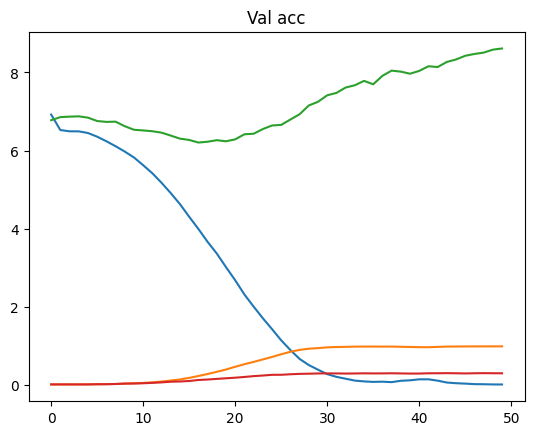

In [62]:
train()